## This notebook reads in TRACK output files and plots TPV tracks 

In [1]:
import re
import numpy as np
import pandas as pd

file = 'tr_trs_VOR500_pos_tp3000_addfld_precip_filt_Z500_1ts_moving_off_box_main_genesis_region.tpv.real_time'
cols = ['time', 'lon', 'lat', 'vorticity', 'precip',  'lon_geo', 'lat_geo',  'geopm', 'id']

In [3]:
# solution 1 
table =pd.read_csv(file, header = None, sep= ' ' ,  names = cols)

In [174]:
table.vorticity.values

array([nan, nan, nan, 'START_TIME', nan, '5.209257e+00', '5.571597e+00',
       '4.203413e+00', '4.544624e+00', '6.491571e+00', '7.254895e+00',
       '5.991777e+00', '6.257481e+00', '6.907203e+00', '6.142330e+00',
       '4.199151e+00', '4.272256e+00', '5.387144e+00', '5.725198e+00',
       '5.435528e+00', '4.158604e+00', '5.013860e+00', '4.278621e+00',
       'START_TIME', nan, '3.556212e+00', '4.946910e+00', '4.107076e+00',
       '3.616633e+00', '6.088832e+00', '4.426823e+00', '3.151931e+00',
       '3.093381e+00', '4.627100e+00', '2.079884e+00', 'START_TIME', nan,
       '2.548481e+00', '4.107351e+00', '3.788909e+00', '2.261224e+00',
       '2.884584e+00', '5.198758e+00', '4.107300e+00', '2.810513e+00',
       '2.670868e+00', '2.466055e+00', '2.587364e+00', '3.546736e+00',
       '2.551617e+00', 'START_TIME', nan, '3.661183e+00', '5.233888e+00',
       '6.354141e+00', '6.359145e+00', '5.147398e+00', '6.756797e+00',
       '6.855370e+00', '4.923291e+00', '4.967427e+00', '4.807598e+

In [6]:
# solution 2 (ignore headers and add track IDs )
tpv =  pd.DataFrame(columns=cols)

with open(file, 'r') as td:
    for line in td:
        if 'TRACK_ID' in line:
            for i in line.split():
                if len(i) == 4:
                    trackid= int(i) 
            
        if len(line) > 50:
            columns = []
            for i in line.split():
                if i != '&':
                    if '2008' in i:
                        columns.append(i)
                    else:
                        columns.append(float(i))
            columns.append(trackid)
            tpv.loc[len(tpv)]= columns
            
# get right data types for dataframe 
tpv['time']=pd.to_datetime(tpv['time'],format='%Y%m%d%H')

In [7]:
# group rows by track ID 
tracks= tpv.groupby(tpv.id)

In [234]:
# select tracks by time
import datetime
date = datetime.datetime(2008,7,19, 18, 0)


In [9]:
# function to derive track coordinates for all tracks which pass through timestep 
# input parameter: timestep in datetime.datetime format 
# returns: dictionary which holds all track lons and lats per trackid , lon and lat values for timestep

def get_tracks_by_date(date):
    keys = []
    values= []
    lon_t = []
    lat_t= []
    times= []
    count = 0 
    for t in tpv.time:
        t= np.datetime64(t).astype(datetime.datetime)
        if t == date:
            print('getting info for', date)
            tid= np.unique(tpv.id[tpv.time== t])
            for tidx in tid:
                lo = tpv.lon[tpv.id == tidx].values
                la = tpv.lat[tpv.id == tidx].values
                lon_t.append(tpv.lon[tpv.id == tidx].values)
                lat_t.append(tpv.lat[tpv.id == tidx].values)
                keys.append(str(tidx))
                values.append([lo, la])
            times.append(tpv.time[tpv.id == tidx])
            count+=1
                

    if count > 0:          
        coords= dict(zip(keys, values))
    else:
        coords = 0 
        print('no tracks available.')
        
    return coords, lon_t, lat_t, times 


In [76]:
t = np.array(times[0])
t[13]

numpy.datetime64('2008-07-21T18:00:00.000000000')

In [10]:
# read in corresponding brightness temperatures 
#file = '/media/juli/Data/third_pole/satellite_data/ncep/NCEP_IR/2008/merg_200806.nc4'

def read_in_netcdf(file):
    from netCDF4 import Dataset
    dataset = Dataset(file)    
    tb= np.array(dataset["Tb"])
    lon= np.array(dataset["lon"])
    lat= np.array(dataset["lat"])
    dataset.close()
    return tb, lon, lat

In [12]:
import datetime
date= datetime.datetime(2008,7,18,12,0)

In [13]:
# call function 
coords, lon_t, lat_t, times = get_tracks_by_date(date)


getting info for 2008-07-18 12:00:00


In [27]:
# get brightness temps by date 
import glob 
yearmonth = str(date.year) + '0'+str(date.month) 
#+ str(date.day) + str(date.hour) 
file = glob.glob('/media/juli/Data/projects/data/satellite_data/ncep/ctt/2008/merg_' + yearmonth +'*.nc4')
tb, lon, lat = read_in_netcdf(file[0])
#tb= np.nanmean(tb,axis =0 ) # average over both 30min steps in hour 


In [28]:
# precip file 

file = '/media/juli/Elements/gpm_v06/2008/gpm_imerg_200807_monthly.nc4'
dataset = xarray.open_dataarray(file)
precip_lat= dataset.lat.values
precip_lon= dataset.lon.values
precip_time= dataset.time.values
precip = dataset.values 

In [25]:
## elevation background 
import xarray 
dem = '/media/juli/Data/projects/data/elevation/elevation_600x350.nc'
elevations = xarray.open_dataarray(dem)
dem= elevations.data

## Test with one timestep














In [97]:
timestep = 948
time_idx = 9
tbb = tb[timestep , 1:, 1:]

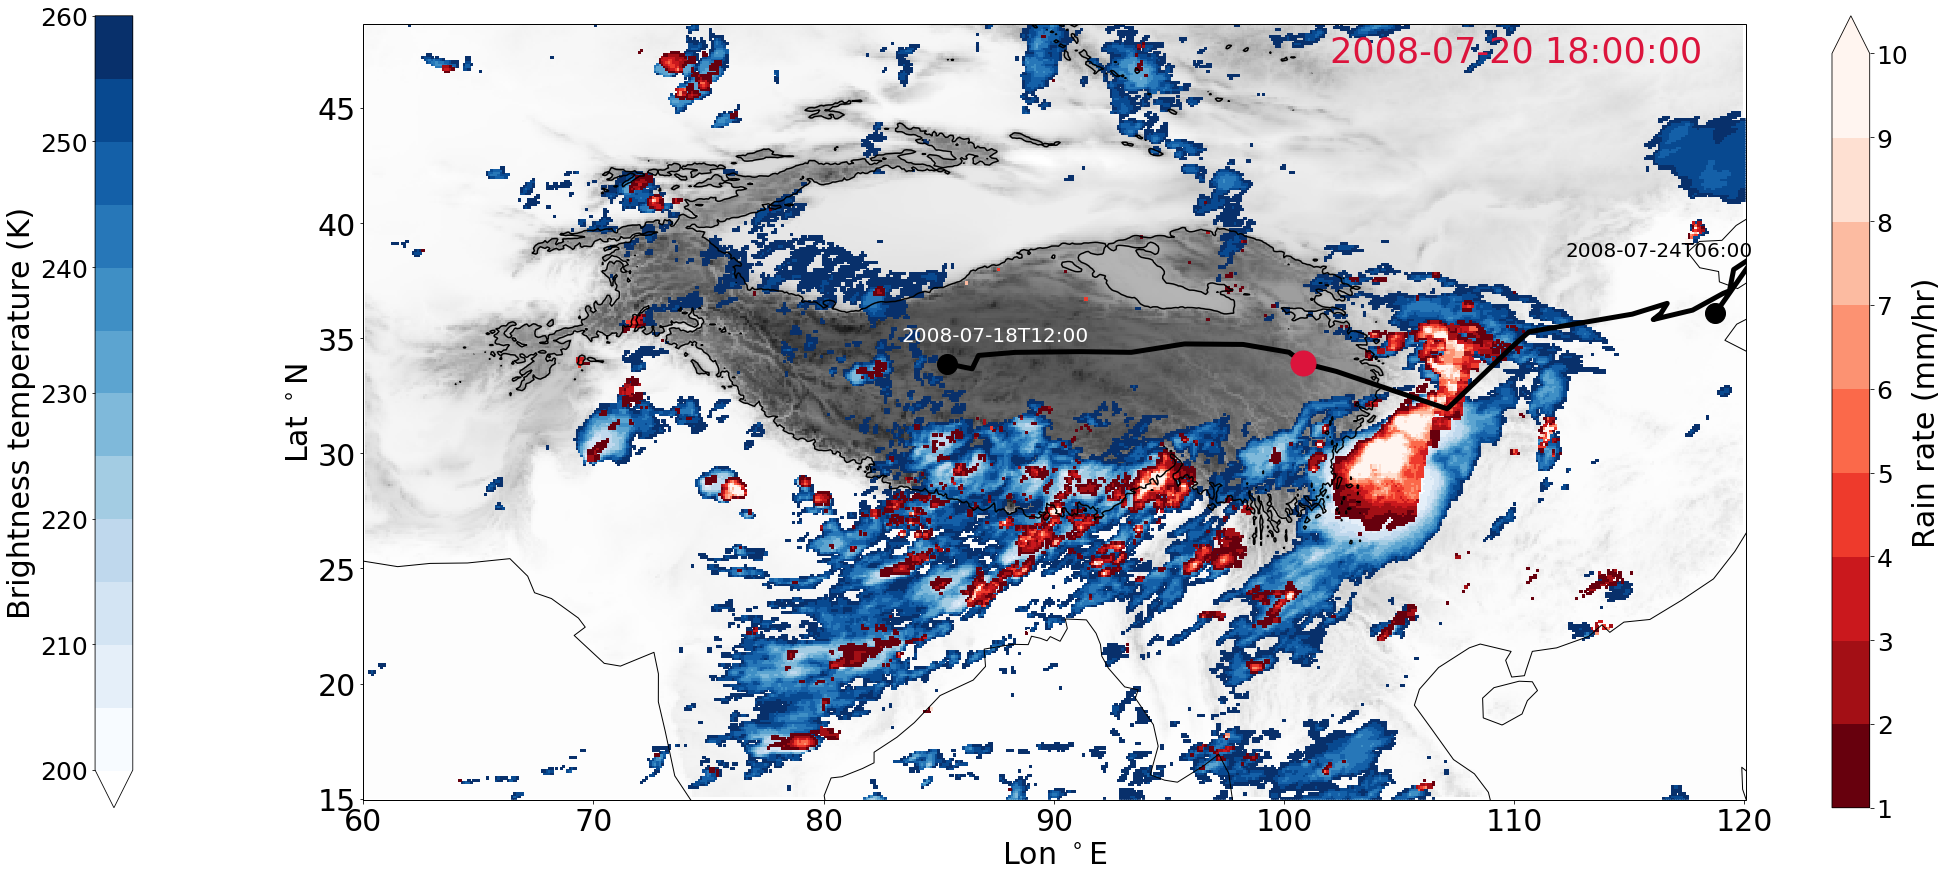

In [171]:
import cartopy
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import shapely.geometry as sgeom
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig = plt.figure(figsize=(32, 11 ))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
ax.set_extent([np.nanmin(lon),np.nanmax(lon),np.min(lat),45])


# TPV track 
for key in coords.keys():
    track_lons = coords[key][0]
    track_lats =  coords[key][1]
    track = sgeom.LineString(zip(track_lons, track_lats))
    ax.add_geometries([track], ccrs.PlateCarree(),facecolor='none', edgecolor='black', linewidth= 5.0)
    

# plot vorticity center of timestep 
ax.plot(lon_t[0][0], lat_t[0][0],transform=ccrs.PlateCarree(), color='black', markersize=20,marker= 'o')

ax.plot(lon_t[0][time_idx], lat_t[0][time_idx],transform=ccrs.PlateCarree(), color='crimson', markersize=25,marker= 'o')

ax.plot(lon_t[0][-1], lat_t[0][-1],transform=ccrs.PlateCarree(), color='black', markersize=20,marker= 'o')


# Elevation 
ax.contour(elevations.lon.values, elevations.lat.values, elevations.values.T, [3000], cmap = 'Greys_r')
ax.pcolormesh(elevations.lon.values,elevations.lat.values, elevations.values.T,  cmap = 'Greys')
ax.coastlines(color = 'k')



# Brightness temperatures 
mcs_example= tbb 
norm = colors.BoundaryNorm(np.arange(200,265,5), cmap.N)
cmap = plt.cm.get_cmap('Blues')
z = np.ma.masked_array(mcs_example, mcs_example >260)
m= ax.pcolormesh(lon, lat, z, transform= ccrs.PlateCarree(), cmap= 'Blues', norm=norm, vmin = 200, vmax = 260 )


# Precipitation 
precip_example = precip[timestep,:,:]
norm = colors.BoundaryNorm(np.arange(1,11,1), cmap.N)
mask = np.ma.masked_array(precip_example, precip_example < 1.0)
p = ax.pcolormesh(precip_lon, precip_lat, mask.T, transform= ccrs.PlateCarree(), cmap= 'Reds_r',norm=norm, vmin = 1.0 , vmax = 10.0)


# Text 
timestr = precip_time[timestep]
ax.text(102, 47, timestr, fontsize = 35, color = 'crimson')
ax.text(lon_t[0][-1] - 6.5, lat_t[0][-1] + 2.5, t[-1].astype(str)[0:16],  fontsize= 20, c= 'black')
ax.text(lon_t[0][0] - 2, lat_t[0][0] + 1 , t[0].astype(str)[0:16], fontsize= 20, c= 'white')


# axis labels 
xlabels=[60,70,80,90,100,110,120]
ylabels= [15, 20,25, 30,35, 40, 45]
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize= 30) 
ax.set_yticklabels(ylabels, fontsize= 30) 
ax.set_yticks(ylabels)
ax.set_xlabel('Lon $^\circ$E', fontsize= 30)
ax.set_ylabel('Lat $^\circ$N', fontsize= 30)

# colorbars
cbar= plt.colorbar(m,extend = 'min', location= 'left')
cbar.set_label('Brightness temperature (K)', fontsize = 30)
cbar.ax.tick_params(labelsize=25) 

cbar2= plt.colorbar(p,extend = 'max', location= 'right')
cbar2.set_label('Rain rate (mm/hr)', fontsize = 30)
cbar2.ax.tick_params(labelsize=25) 

ax.set_aspect('equal')

plt.savefig('tpv_mcs_20080720_18:00UTC.png', bbox_inches="tight", dpi = 300)

plt.show()

## Function to create tbb-track plots by date 

In [432]:
def plot_tracks_by_date(date):
    
    ## Get track info for date 
    coords, lon_t, lat_t, times= get_tracks_by_date(date)
    lon_t= np.array(lon_t)[0]
    lat_t= np.array(lat_t)[0]

    # get next timestep in track 
    for idx,time in enumerate(times[0]):
        print('timestep:', time)
        date= np.datetime64(time).astype(datetime.datetime)

        
        ###################################################################

        # Get brightness temps by date 
        import glob 
        if date.hour <10:
            h = '0' + str(date.hour)
        else:
            h= str(date.hour)
            
        if date.month <10:
            m = '0' + str(date.month)
        else:
            m= str(date.month)
            
        hour = str(date.year) + m + str(date.day) + h
        file = glob.glob('/media/juli/Data/third_pole/satellite_data/ncep/2008/tp/merg_' + hour +'*.nc4')
        print('getting brightness temperatures for file   ', file[0])
        tb, lons, lats = read_in_netcdf(file[0])
        tb= np.nanmean(tb,axis =0 ) # average over both 30min steps in hour 
        

        ###################################################################

        ## Plot 
        import cartopy
        import matplotlib.pyplot as plt 
        import cartopy.crs as ccrs
        import cartopy.io.shapereader as shpreader
        import matplotlib.patches as mpatches
        import matplotlib.pyplot as plt
        import shapely.geometry as sgeom
        from cartopy.feature import ShapelyFeature
        from cartopy.io.shapereader import Reader
        import matplotlib.colors as colors


        shpfilename= '/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
        #reader = shpreader.Reader(shpfilename)

        shape_feature = ShapelyFeature(Reader(shpfilename).geometries(),
                                        ccrs.PlateCarree(),facecolor='none', edgecolor='black' , linewidth = 3.0)
        fig = plt.figure(figsize=(20, 17))
        ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())

        ax.set_extent([70, 130, 15, 50], ccrs.PlateCarree())

        shapename = 'admin_1_states_provinces_lakes_shp'

        # turn the lons and lats into a shapely LineString
        for key in coords.keys():
            track_lons = coords[key][0]
            track_lats =  coords[key][1]
            track = sgeom.LineString(zip(track_lons, track_lats))
            ax.add_geometries([track], ccrs.PlateCarree(),facecolor='none', edgecolor='magenta', linewidth= 4.0)


        # add points and shapefile 
        ax.add_feature(shape_feature)

        # plot brightness temperatures 
        bounds= np.array([200, 210, 220, 230,240,250, 260, 270, 280, 290 ])
        norm = colors.BoundaryNorm(boundaries=bounds, ncolors= 256)
        cmap = plt.cm.get_cmap('twilight_shifted')

        ax.pcolormesh(lons, lats, tb,transform=ccrs.PlateCarree(), cmap = cmap, norm = norm)


        # plot point of timestep 
        ax.plot(lon_t[idx], lat_t[idx],transform=ccrs.PlateCarree(), color='magenta', markersize=20,marker= 'o')

        
        plt.title(hour, fontsize= 40)
        #plt.show()
        plt.savefig('/media/juli/Data/third_pole/mcs_tracking/TPV/plots/tpv_'+ hour +'.png')



## 12th July, 2008, 12:00 

In [431]:
for i in np.unique(tpv.id.values):
    nr_timesteps= np.shape(tpv[tpv.id == i])[0]
    print(i, nr_timesteps, tpv.time[tpv.id == i])

1022 18 0    2008-01-29 18:00:00
1    2008-01-30 00:00:00
2    2008-01-30 06:00:00
3    2008-01-30 12:00:00
4    2008-01-30 18:00:00
5    2008-01-31 00:00:00
6    2008-01-31 06:00:00
7    2008-01-31 12:00:00
8    2008-01-31 18:00:00
9    2008-02-01 00:00:00
10   2008-02-01 06:00:00
11   2008-02-01 12:00:00
12   2008-02-01 18:00:00
13   2008-02-02 00:00:00
14   2008-02-02 06:00:00
15   2008-02-02 12:00:00
16   2008-02-02 18:00:00
17   2008-02-03 00:00:00
Name: time, dtype: datetime64[ns]
1103 10 18   2008-02-14 18:00:00
19   2008-02-15 00:00:00
20   2008-02-15 06:00:00
21   2008-02-15 12:00:00
22   2008-02-15 18:00:00
23   2008-02-16 00:00:00
24   2008-02-16 06:00:00
25   2008-02-16 12:00:00
26   2008-02-16 18:00:00
27   2008-02-17 00:00:00
Name: time, dtype: datetime64[ns]
2418 13 28   2008-03-12 12:00:00
29   2008-03-12 18:00:00
30   2008-03-13 00:00:00
31   2008-03-13 06:00:00
32   2008-03-13 12:00:00
33   2008-03-13 18:00:00
34   2008-03-14 00:00:00
35   2008-03-14 06:00:00
36   200

getting info for 2008-08-25 18:00:00
timestep: 2008-08-25 12:00:00
getting brightness temperatures for file    /media/juli/Data/third_pole/satellite_data/ncep/2008/tp/merg_2008082512_4km-pixel.nc4
timestep: 2008-08-25 18:00:00
getting brightness temperatures for file    /media/juli/Data/third_pole/satellite_data/ncep/2008/tp/merg_2008082518_4km-pixel.nc4
timestep: 2008-08-26 00:00:00
getting brightness temperatures for file    /media/juli/Data/third_pole/satellite_data/ncep/2008/tp/merg_2008082600_4km-pixel.nc4
timestep: 2008-08-26 06:00:00
getting brightness temperatures for file    /media/juli/Data/third_pole/satellite_data/ncep/2008/tp/merg_2008082606_4km-pixel.nc4
timestep: 2008-08-26 12:00:00
getting brightness temperatures for file    /media/juli/Data/third_pole/satellite_data/ncep/2008/tp/merg_2008082612_4km-pixel.nc4
timestep: 2008-08-26 18:00:00
getting brightness temperatures for file    /media/juli/Data/third_pole/satellite_data/ncep/2008/tp/merg_2008082618_4km-pixel.nc4
tim

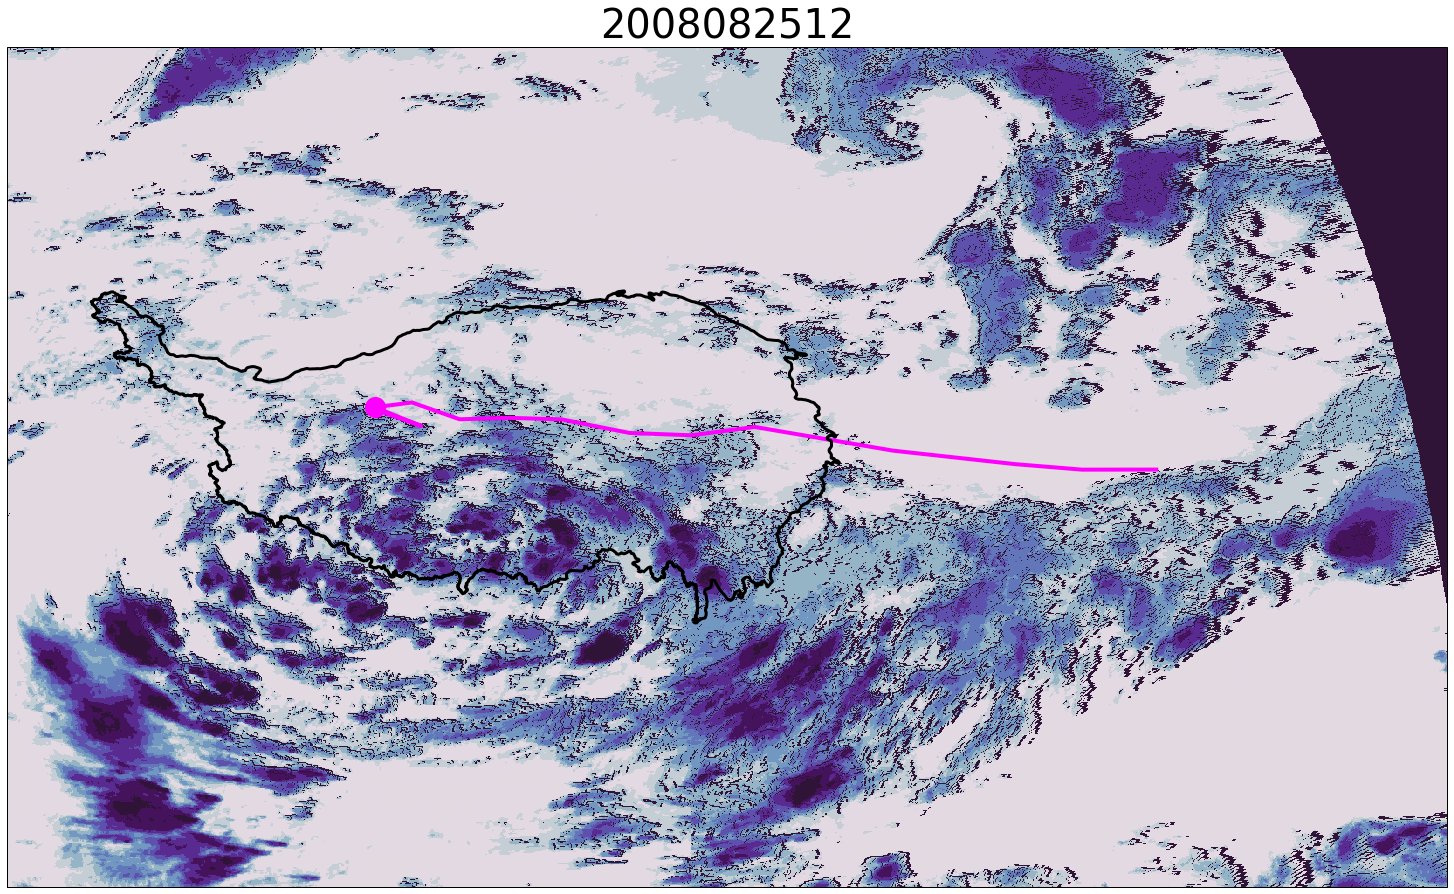

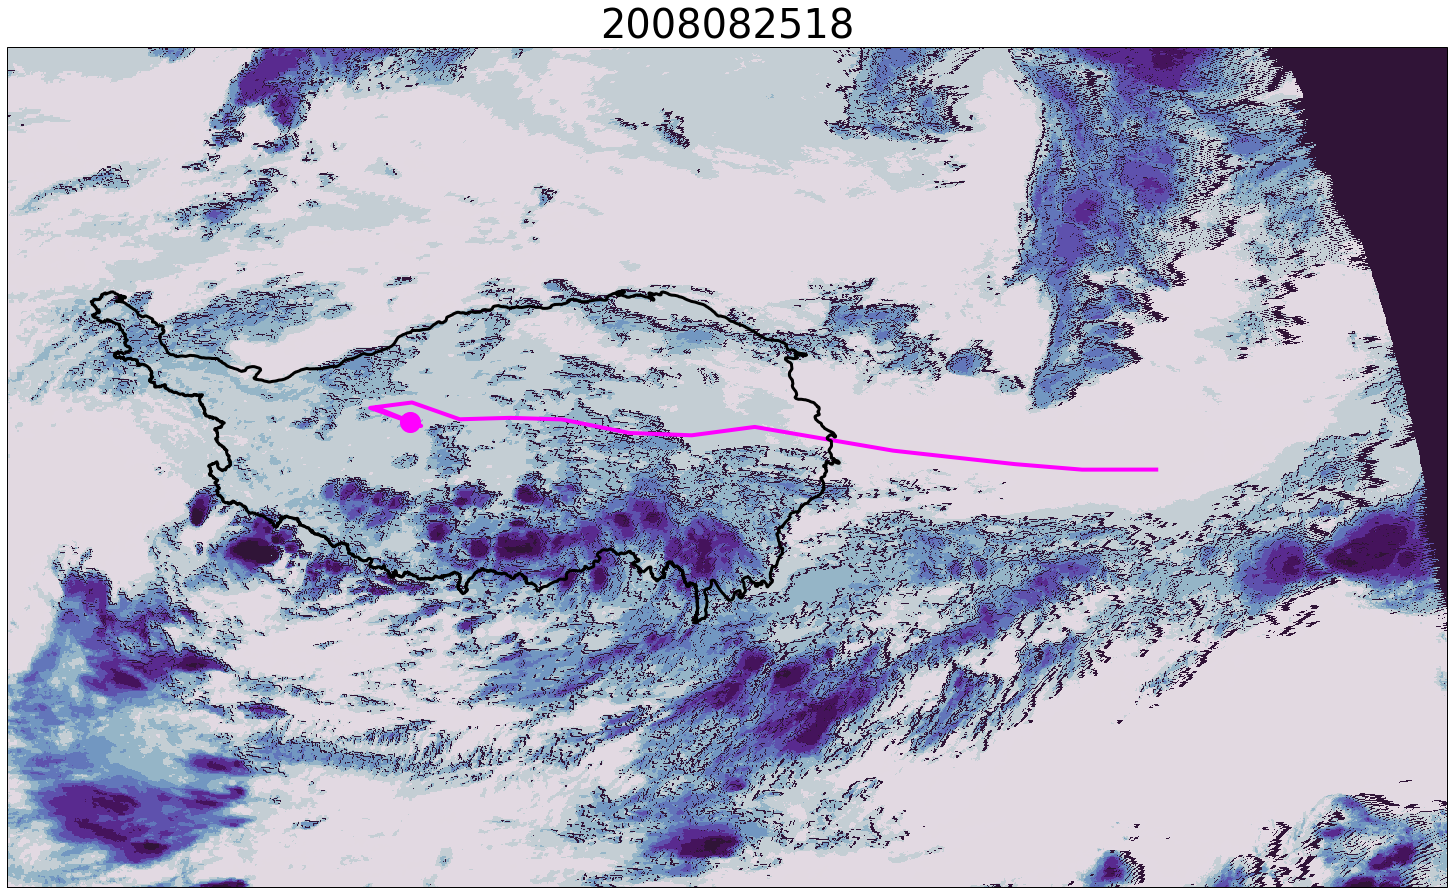

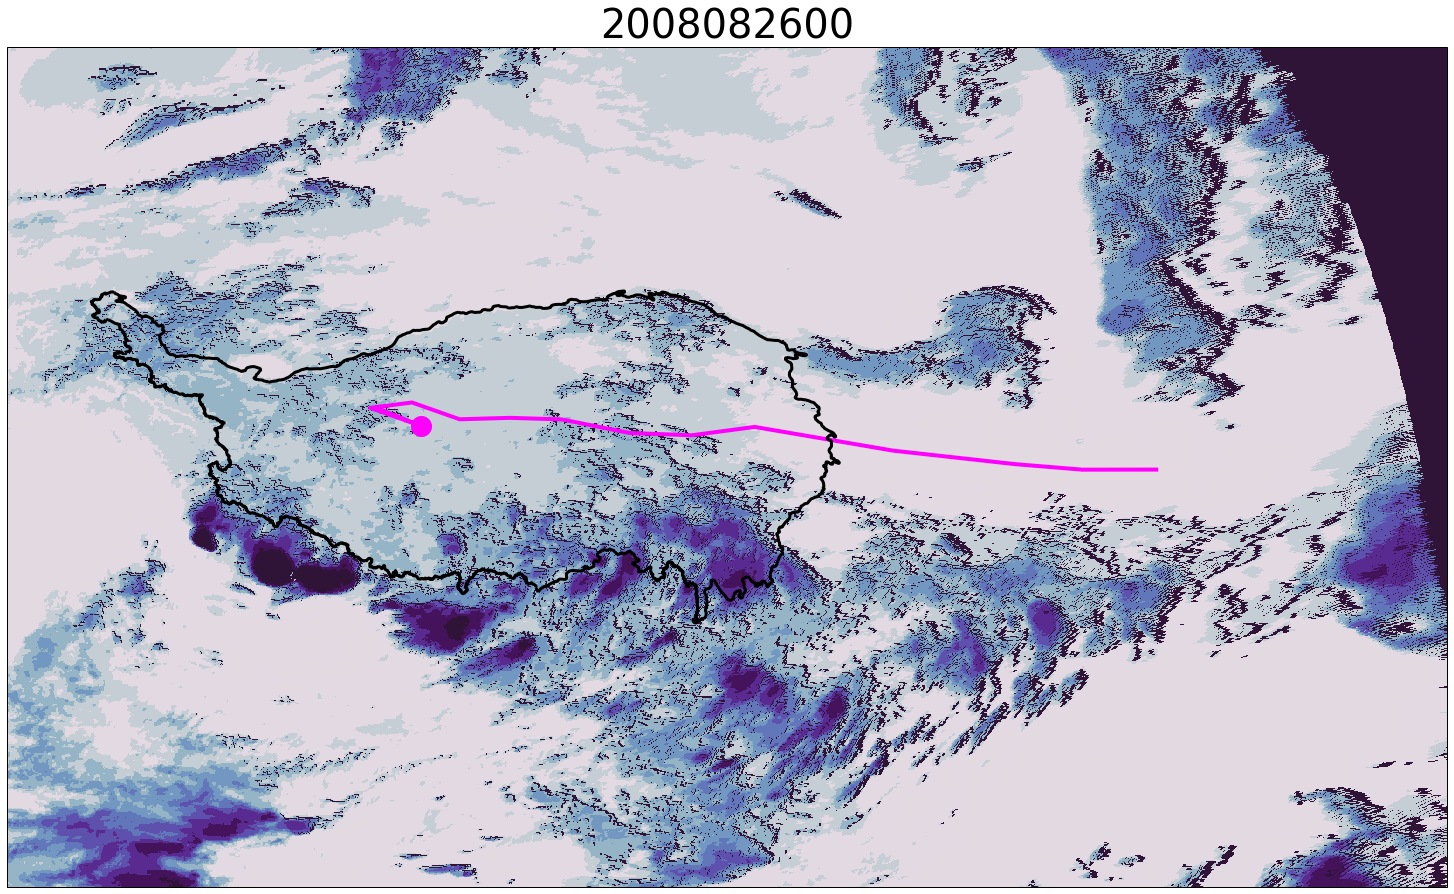

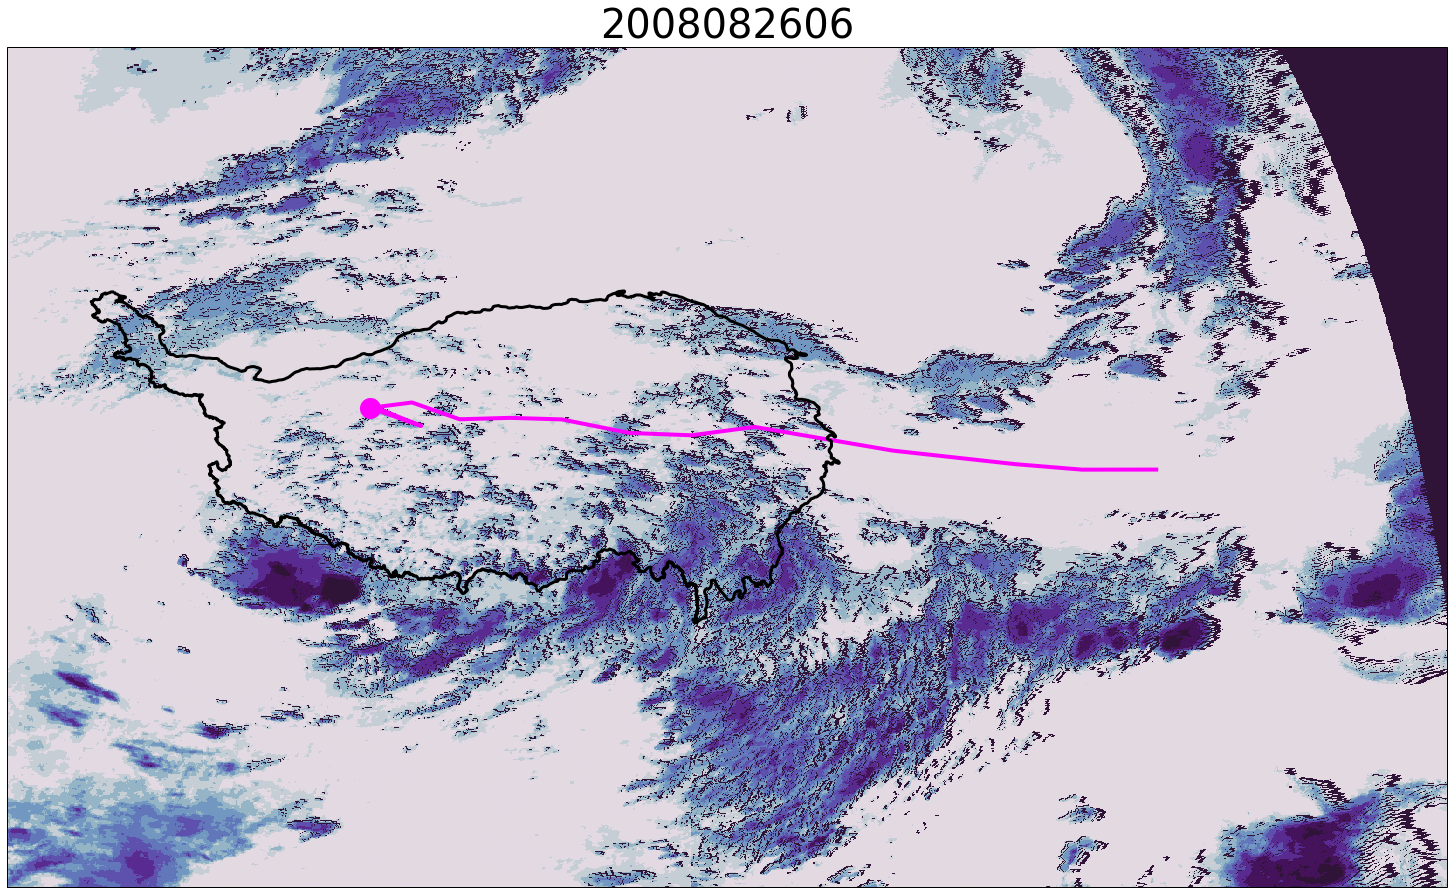

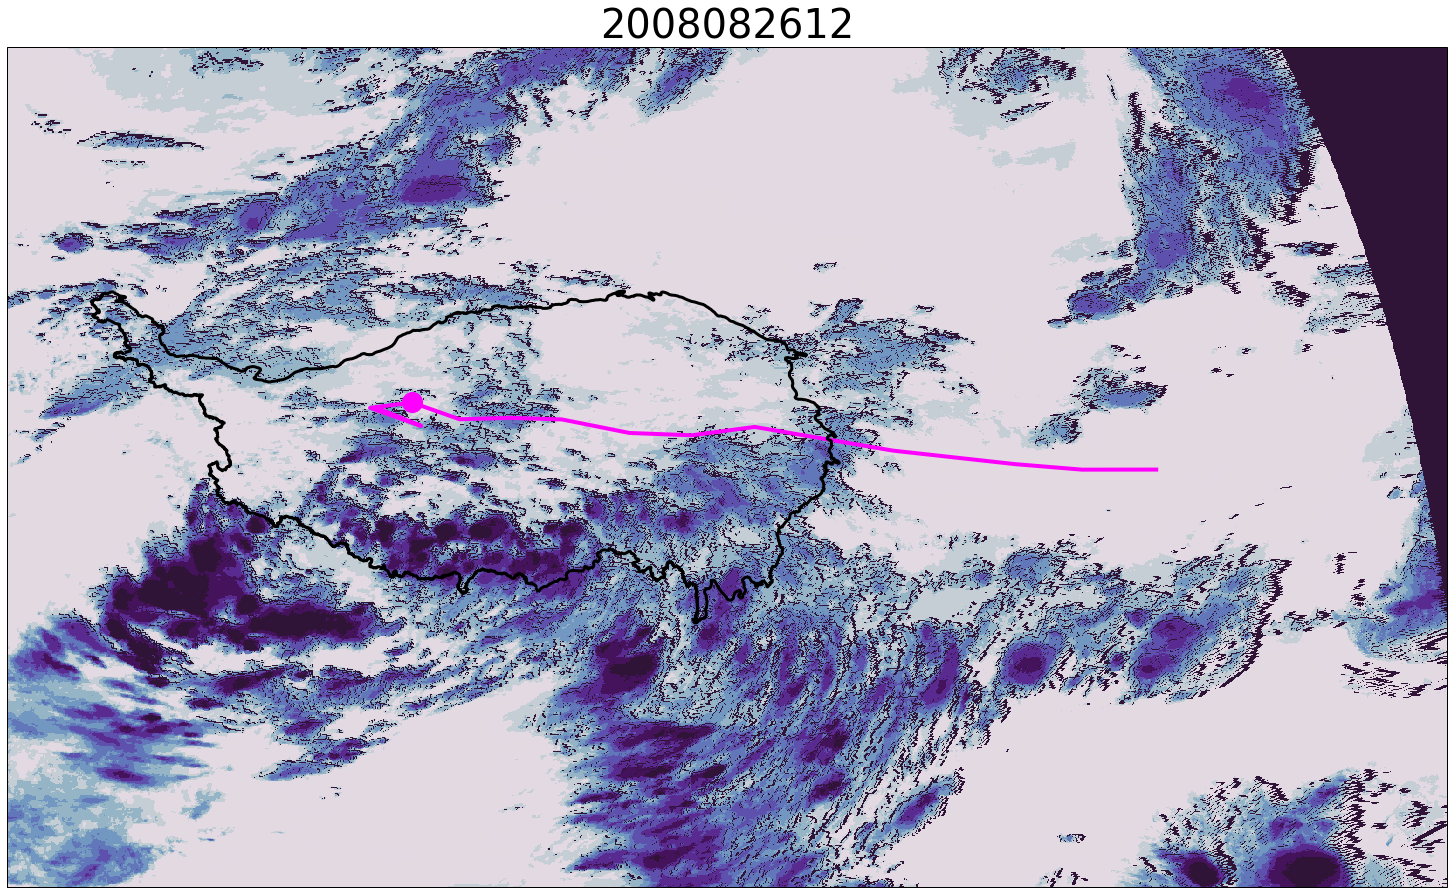

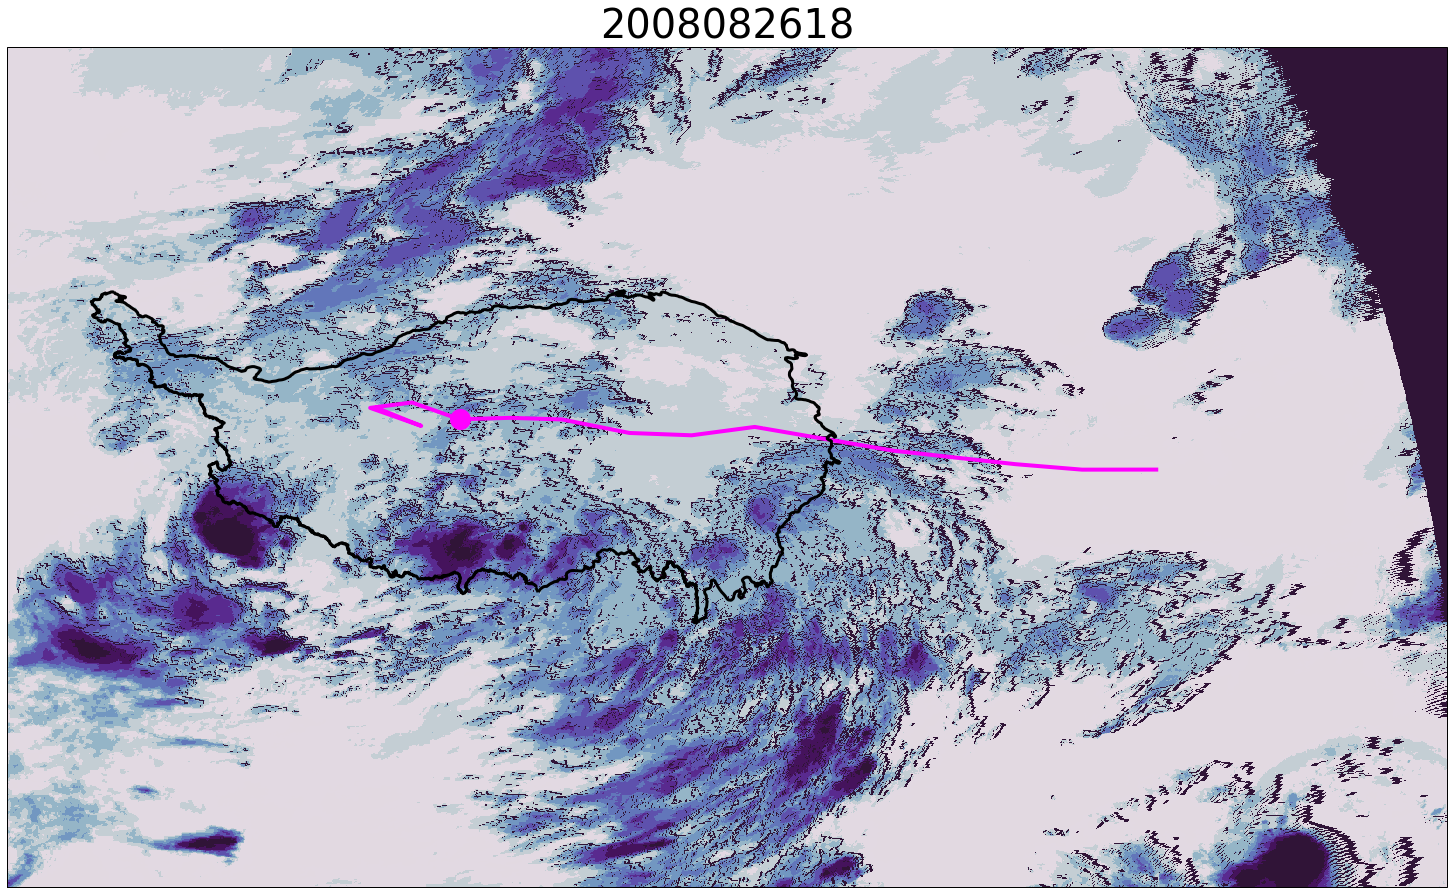

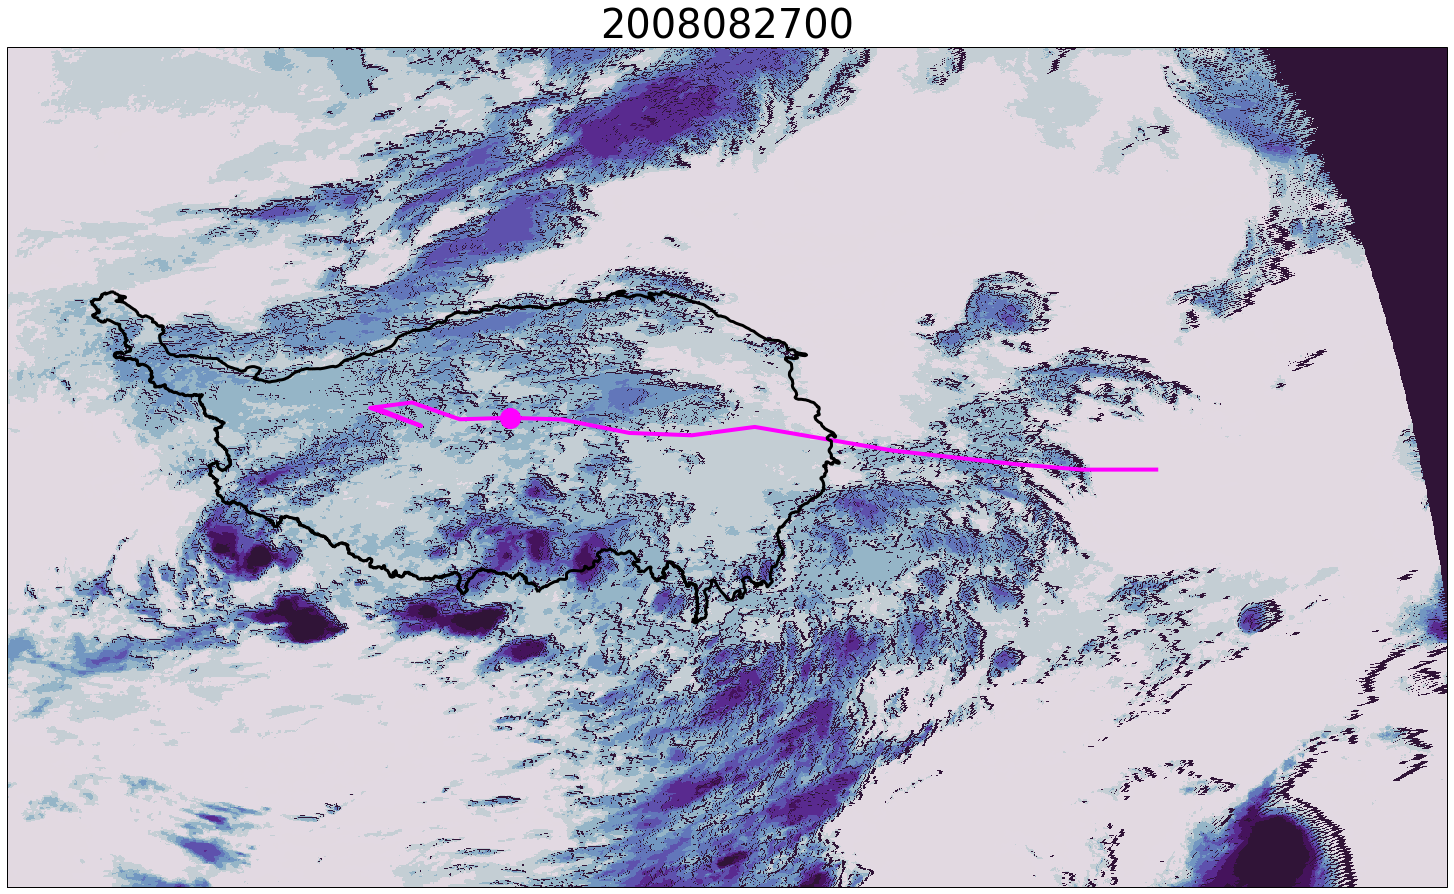

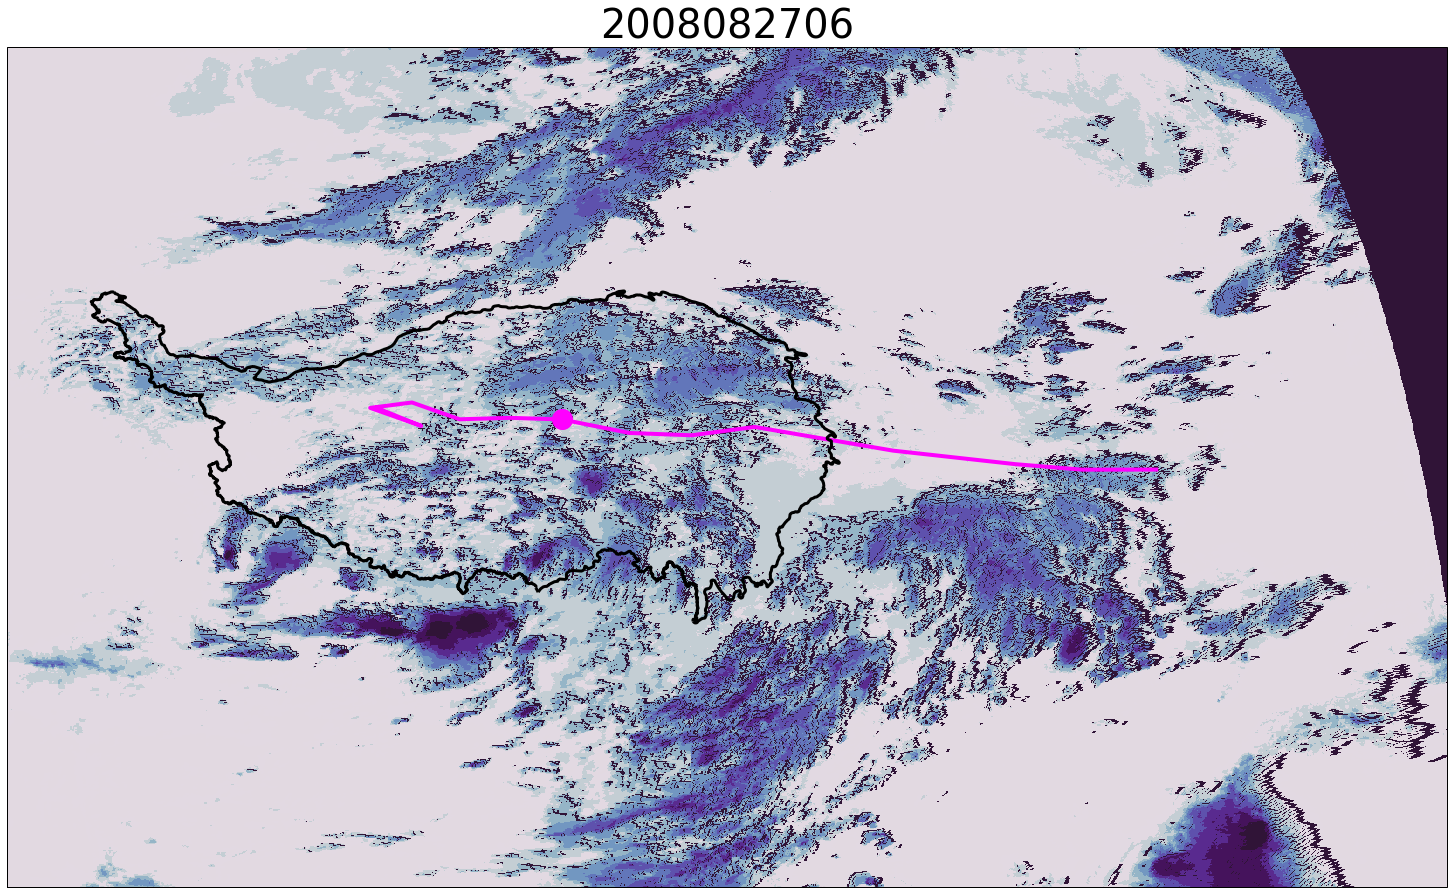

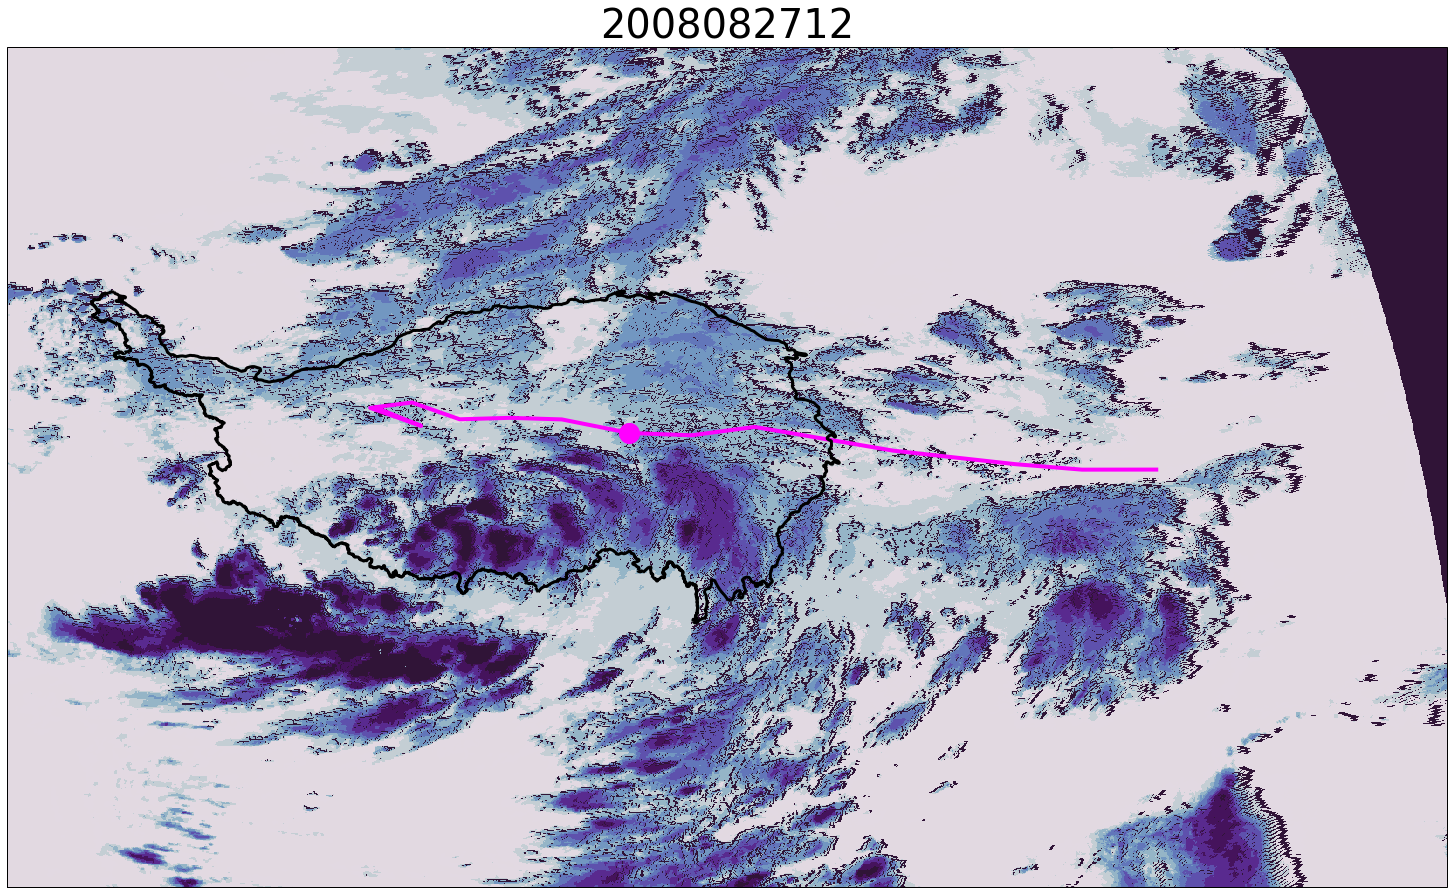

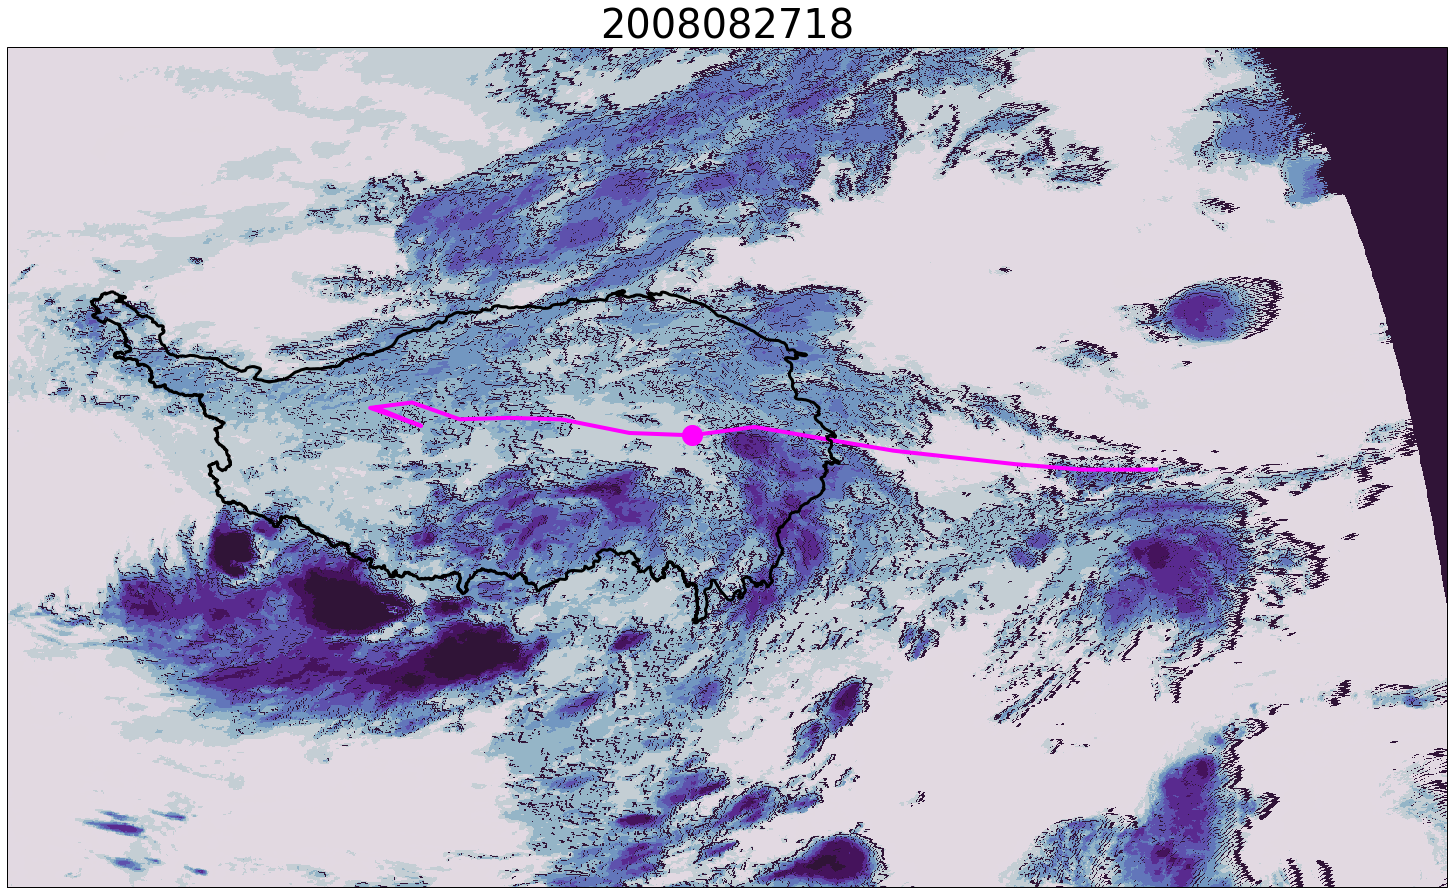

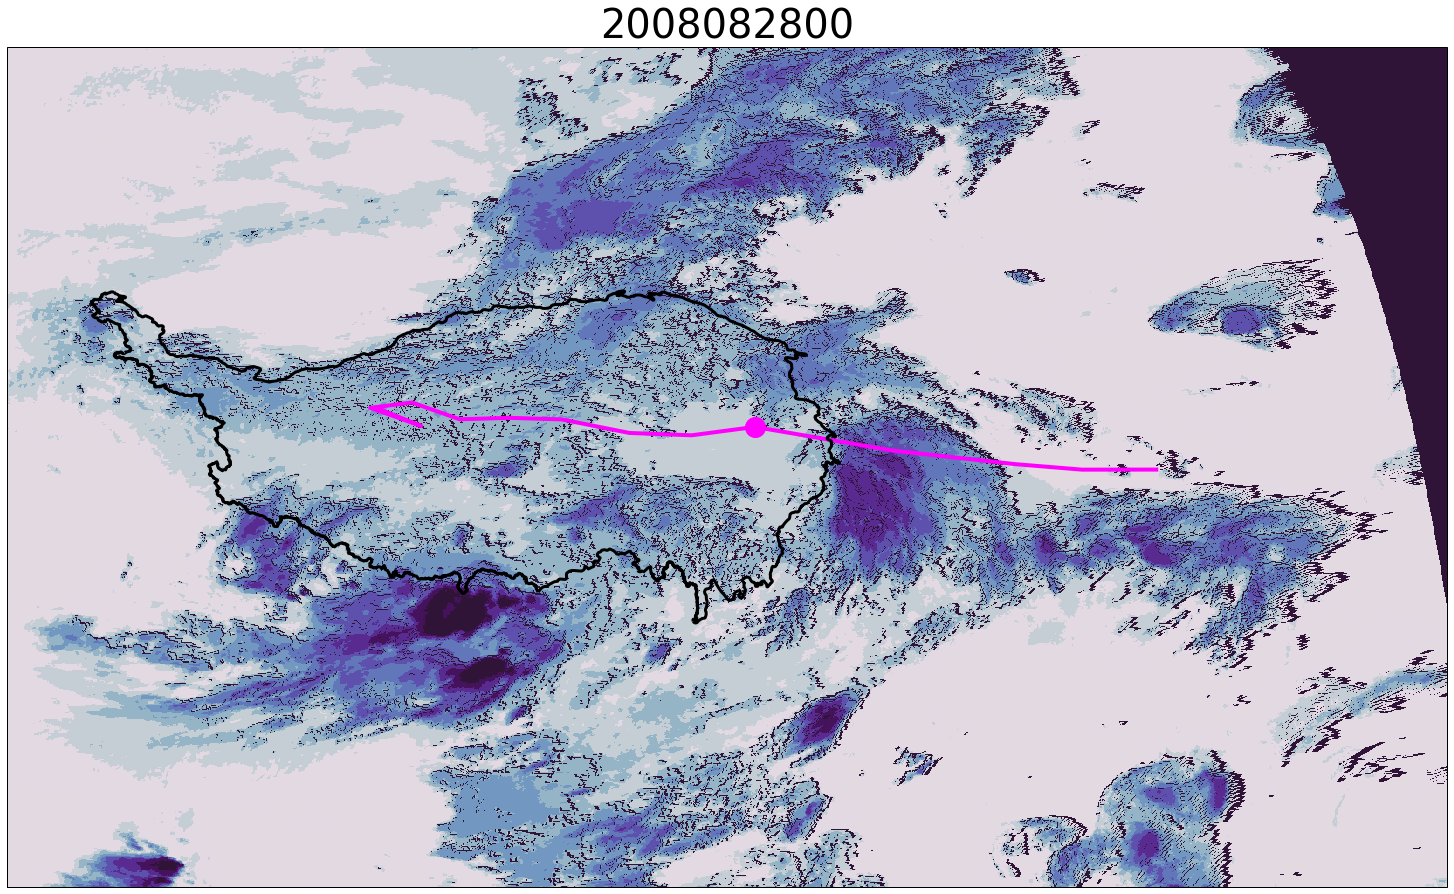

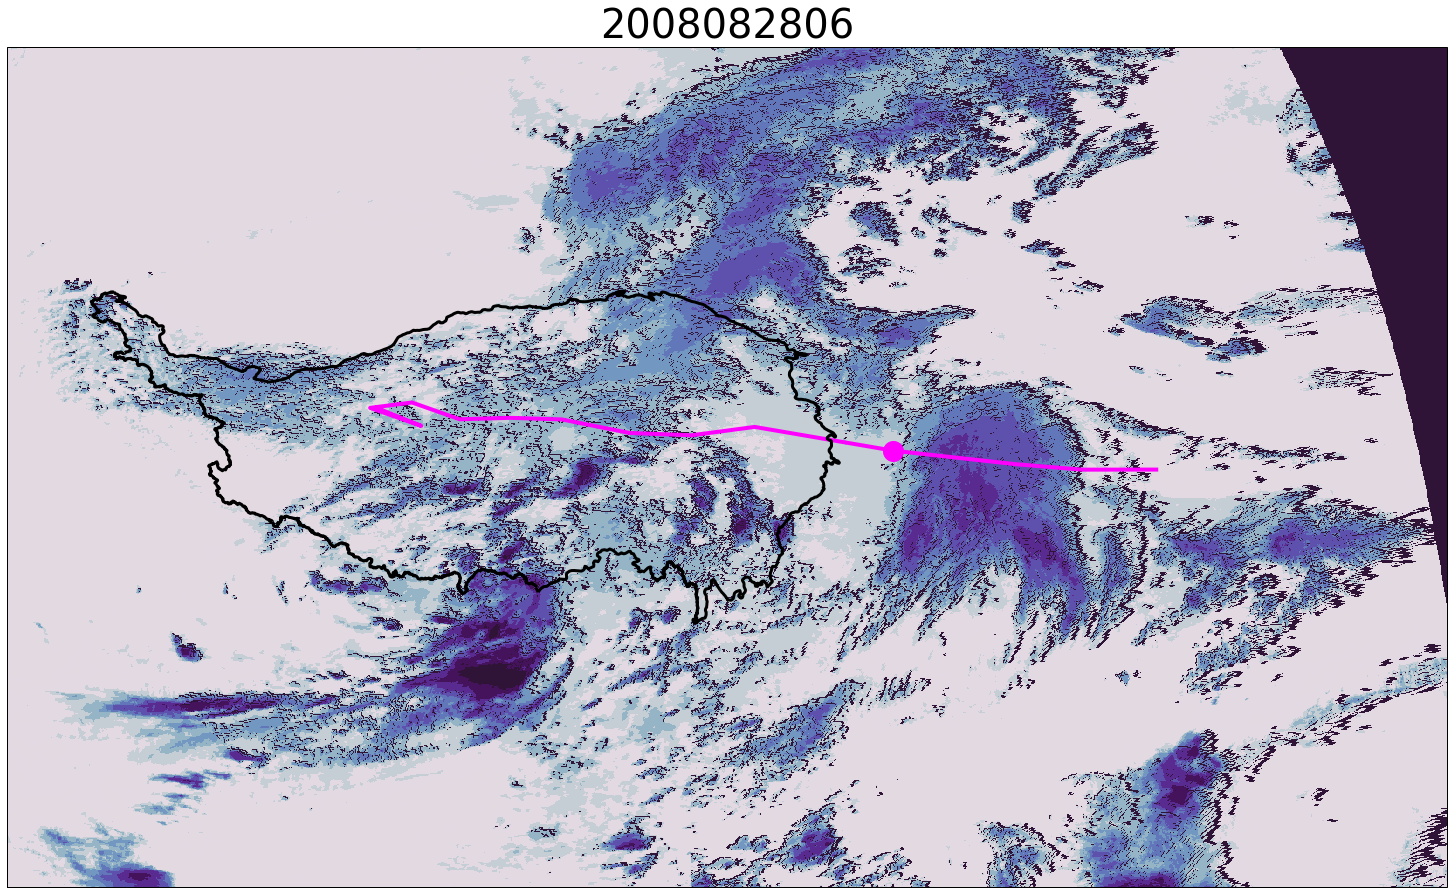

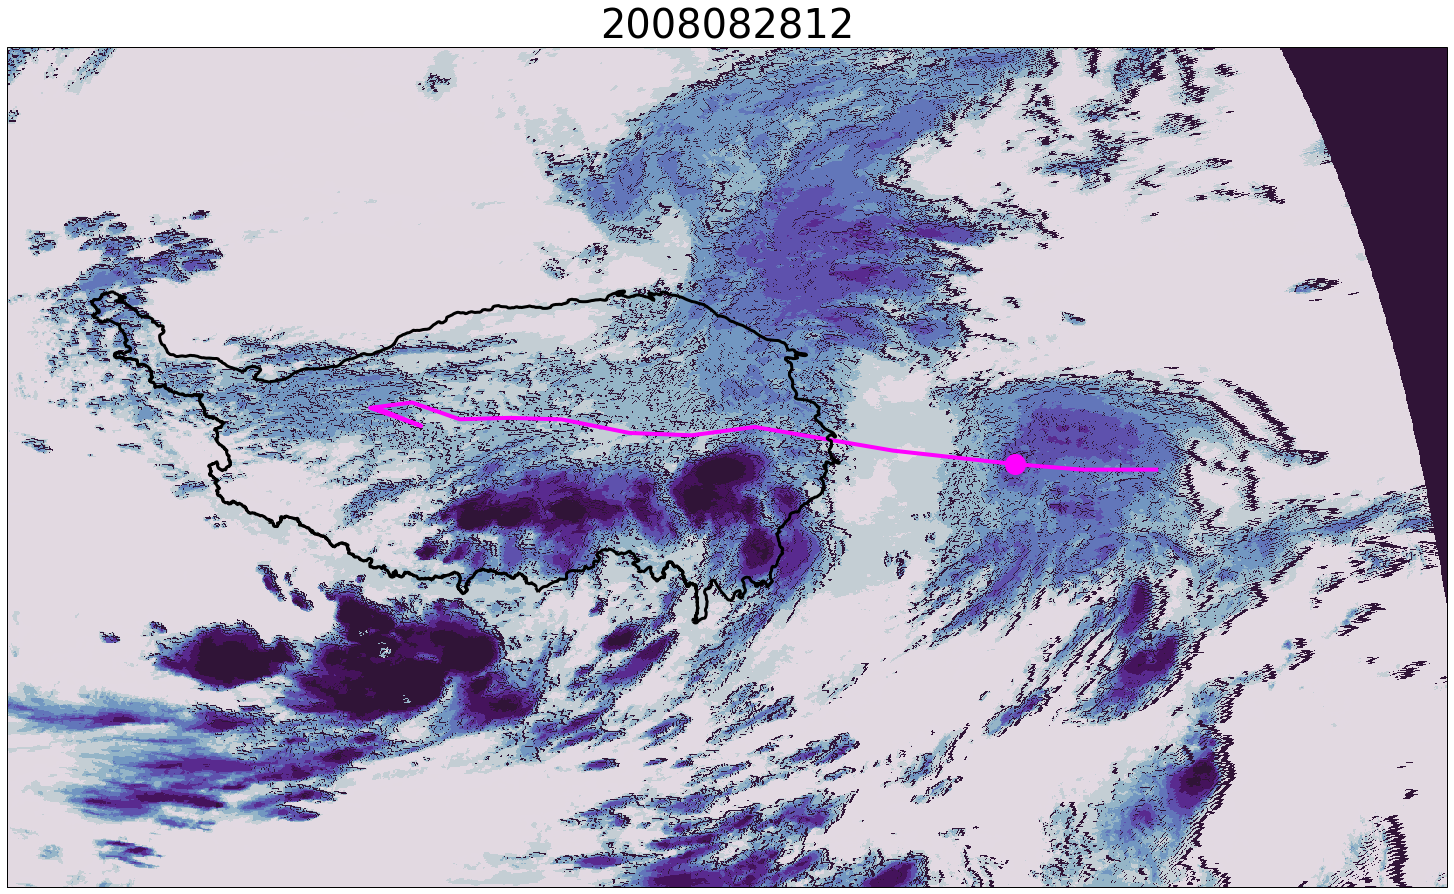

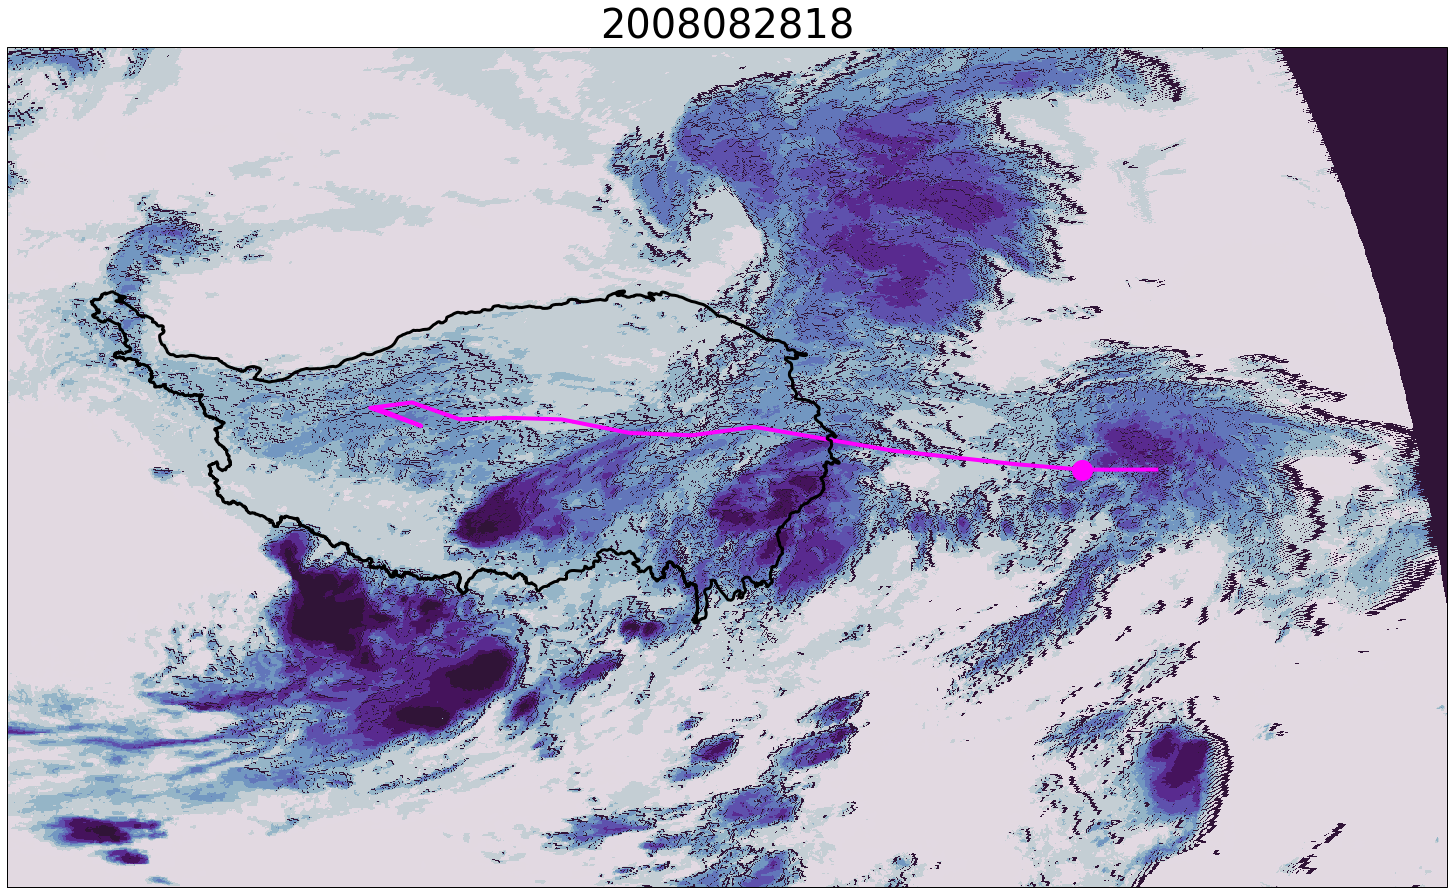

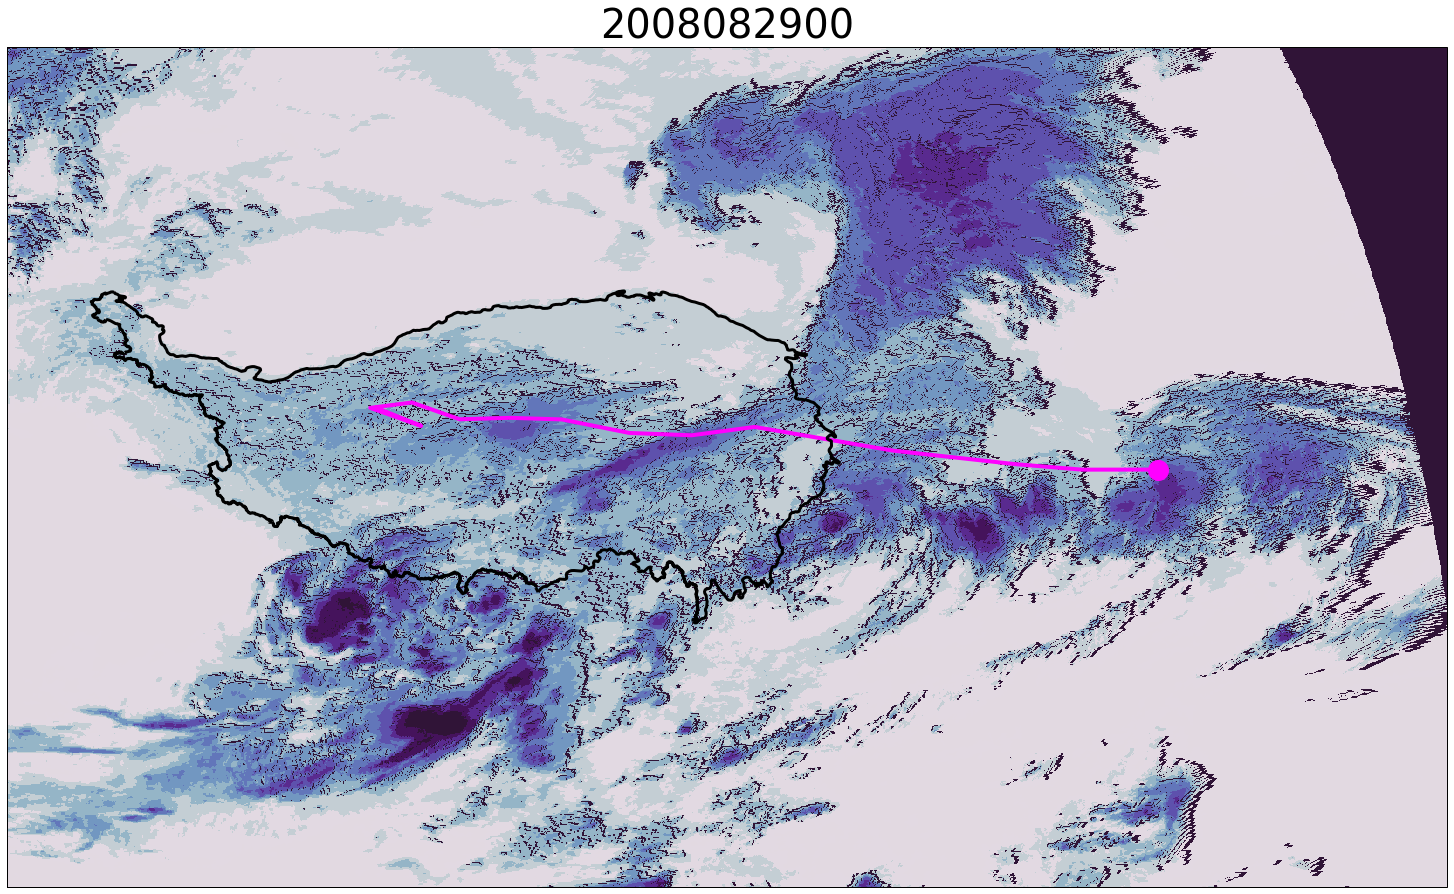

In [437]:
# choose starting date here! 
date = datetime.datetime(2008,8,25,18, 0)
plot_tracks_by_date(date)

## notes 

- timeseries with all tracks/ plot multiple tracks if present 

- include a few timesteps before 
- wind field and precip/moisture (e.g. from HAR data )